In [94]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
#-------------------------------ML Imports--------------------------------------
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#-------------------------------Database Imports-------------------------------------------
from Database import creating_engine, creating_session, closing_session, disposing_engine

### Extract and Explore

In [95]:
url = "https://storage.googleapis.com/the_public_bucket/wine-clustering.csv"
file_path = "data/raw_wine.csv"

# Get request to download the CSV file
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Open the local file in binary write mode
    with open(file_path, 'wb') as f:
        # Write the content data from the response into the local file
        f.write(response.content)
    print("The CSV file has been downloaded and saved successfully '{}'.".format(file_path))
else:
    print("Error downloading the CSV file. Status code:", response.status_code)


The CSV file has been downloaded and saved successfully 'data/raw_wine.csv'.


Read the csv as a Dataframe 

In [96]:
df=pd.read_csv("data/raw_wine.csv")
df.head(2)

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050


How many variables of each data type do we have in the dataset?

In [97]:
(
    df
    .dtypes
    .value_counts()
)

float64    11
int64       2
Name: count, dtype: int64

What are the dimesions of the dataset?

In [98]:
df.shape

(178, 13)

If there are observations with null values, how many do we have for each variable?

In [99]:
(
    df
    .isnull()
    .sum()
    .sort_values(ascending=False)
)

Alcohol                 0
Malic_Acid              0
Ash                     0
Ash_Alcanity            0
Magnesium               0
Total_Phenols           0
Flavanoids              0
Nonflavanoid_Phenols    0
Proanthocyanins         0
Color_Intensity         0
Hue                     0
OD280                   0
Proline                 0
dtype: int64

Are there any duplicates? 

In [100]:
df.duplicated().any()

False

In [101]:
df.describe()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


As we can see in the last cell, the attributes don't have the same scale, let's check what's the range of each variable

In [102]:
description = df.describe()
# Get the min and max values for each column
min_values = description.loc['min']
max_values = description.loc['max']

print("Variable             | Minimun  | Maximun")
print("-" * 50)
for column in description.columns:
    min_value = description[column]['min']
    max_value = description[column]['max']
    print(f"{column:<20} | {min_value:<8} | {max_value:<8}")

Variable             | Minimun  | Maximun
--------------------------------------------------
Alcohol              | 11.03    | 14.83   
Malic_Acid           | 0.74     | 5.8     
Ash                  | 1.36     | 3.23    
Ash_Alcanity         | 10.6     | 30.0    
Magnesium            | 70.0     | 162.0   
Total_Phenols        | 0.98     | 3.88    
Flavanoids           | 0.34     | 5.08    
Nonflavanoid_Phenols | 0.13     | 0.66    
Proanthocyanins      | 0.41     | 3.58    
Color_Intensity      | 1.28     | 13.0    
Hue                  | 0.48     | 1.71    
OD280                | 1.27     | 4.0     
Proline              | 278.0    | 1680.0  


> Now that we know variables have different range of values, we must keep in mind that is important to normalize the data before we proceed with any clustering technique. **This will be done during the Transformation phase**


What about the distribution of the attributes? 

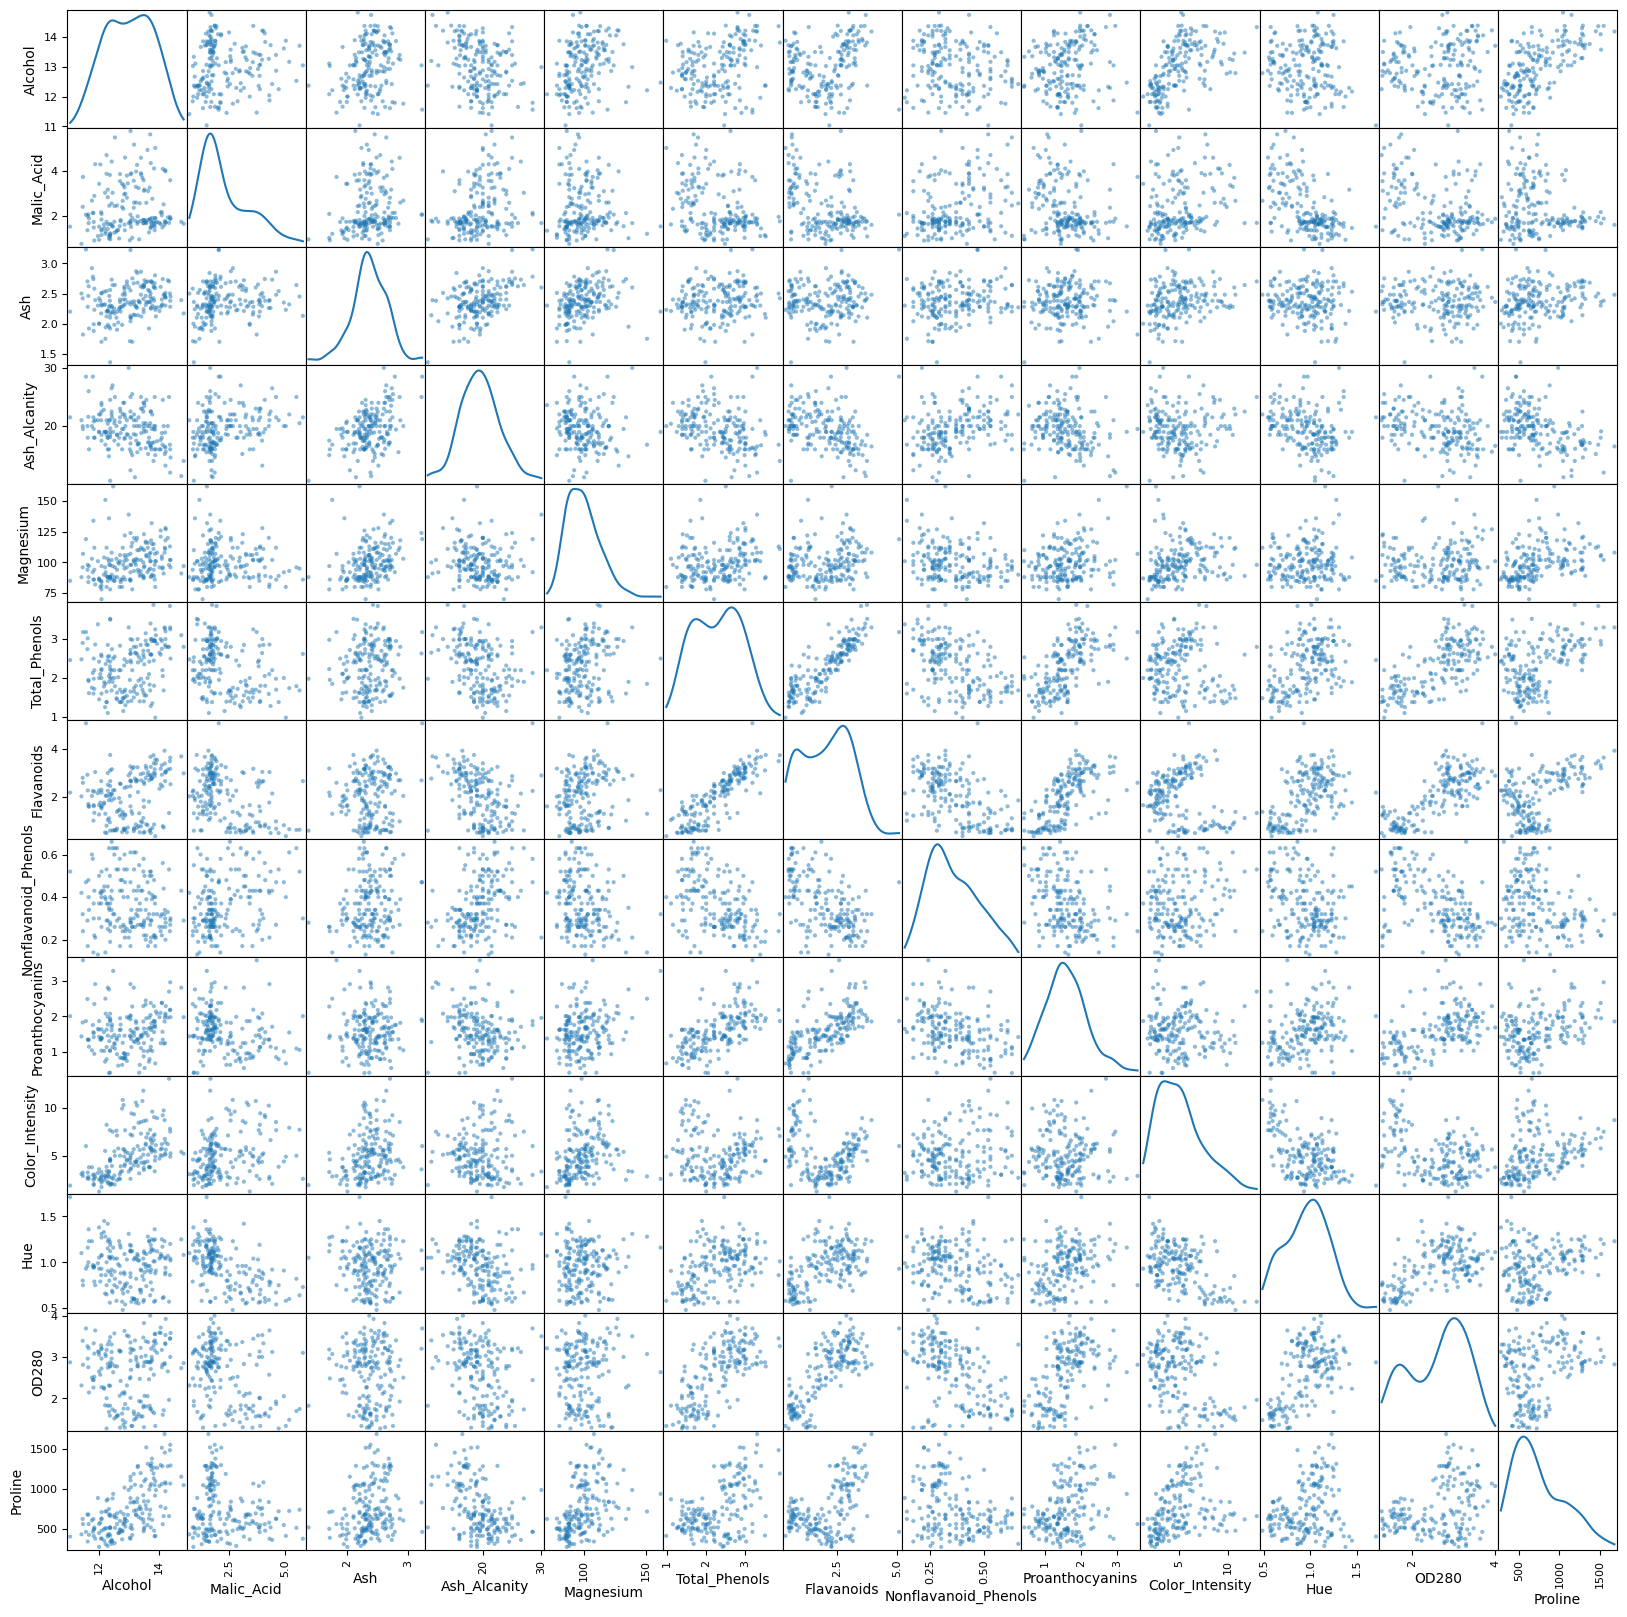

In [103]:
graph = pd.plotting.scatter_matrix(df, figsize=(20,20), diagonal='kde')

If we take a look at the scatter plot, it becomes evident that certain attributes are strongly correlated. For instance, "Total_Phenols" and "Flavanoid" exhibit a notable correlation. However, it would be more convenient to identify these patterns through a correlation matrix.

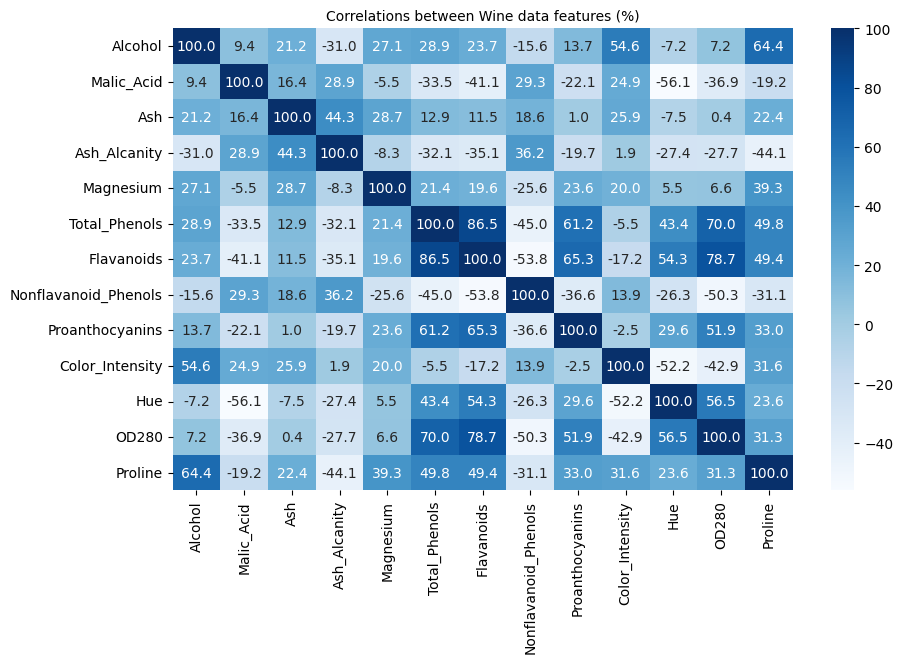

In [104]:
corr = df.corr() * 100

plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True,cmap='Blues',fmt=".1f")
plt.title('Correlations between Wine data features (%)', fontsize=10)
plt.show()

### Transform

> *Note: Upon exploration, it became evident that the dataset does not required any cleaning. Consequently, the transformation phase will involve normalizing the data, then, the K-means will be implemented.*

##### Feature Selection

In [105]:
df = df[['Alcohol', 'Total_Phenols', 'Flavanoids', 'Proanthocyanins', 'OD280', 'Proline']]

##### K-Means

This algorithm requires determining the number of clusters we want to have. However, the problem doesn't offer any guidance regarding the optimal number of clusters. Therefore, I will employ the Elbow Method to determine the appropriate number of clusters that should be used.

>*Note: Before applying the Elbow's method, the data will be standardized.*

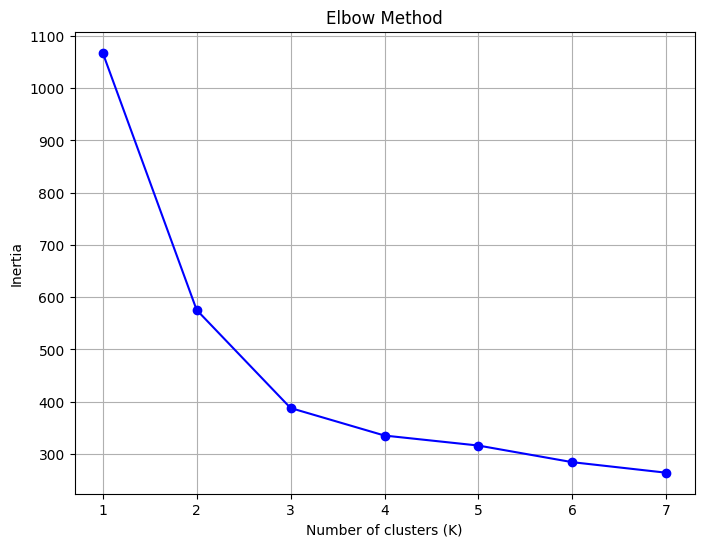

In [106]:
# Elbow Method 
numeric_data = df.select_dtypes(include=['float64', 'int64'])
scaled_data = StandardScaler().fit_transform(numeric_data)

inertia_values = [] 
k_values = range(1, 8)  
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42) # We initialize and fit the KMeans model with K clusters.
    kmeans.fit(scaled_data)
    inertia_values.append(kmeans.inertia_) # We save the inertia in the list.

plt.figure(figsize=(8, 6)) 
plt.plot(k_values, inertia_values, marker='o', linestyle='-', color='blue')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

The Elbow method suggets that the appropiate number of clusters should be 3. Now let's apply the K-Means 

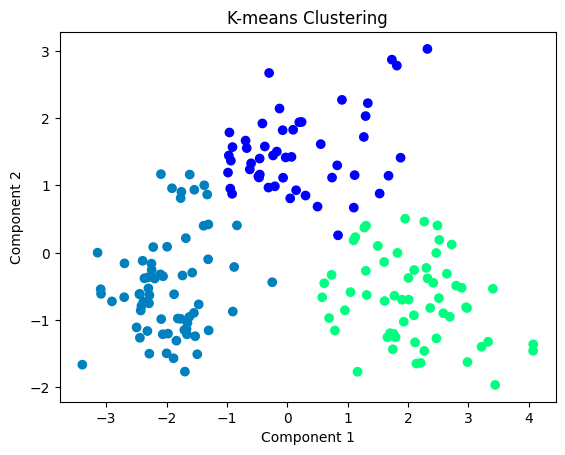

In [107]:
kmeans = KMeans(n_clusters=3, algorithm='elkan')
kmeans.fit(scaled_data) 
cluster_labels = kmeans.labels_ 
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='winter')
plt.title('K-means Clustering')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

Looking at the results, each segmented group is visually represented by a different color on the scatter plot. The K-Means divides our data into 3 clusters and I'm going to suppose that each cluster represents a cultivar, the labels are going to be set in the dataset in order to develop some analysis... 

In [108]:
df['Cultivar'] = cluster_labels

#Since the clusters starts from 0, let's map the results to make sense
mapping = {0:1, 1:2, 2:3}
df['Cultivar'] = df['Cultivar'].map(mapping)
df.head(2)

,Alcohol,Total_Phenols,Flavanoids,Proanthocyanins,OD280,Proline,Cultivar
0,14.23,2.80,3.06,2.29,3.92,1065,3
1,13.20,2.65,2.76,1.28,3.40,1050,3


>At this point, it is appropriate to test the algorithm, however, in order to create a confusion matrix it is neccesary to have data properly labeled, which is not the case.

### Load

At this point, we already know to which cultivar each record belongs. Now, we are going to upload the data to a Postgres database and connect from Power BI to identify valuable information

In [109]:
# Create the engine and the session
engine = creating_engine()
session = creating_session(engine)

# Load data into the database.
table = "wine_labeled"
df.to_sql(table, engine, if_exists="replace", index=False)

# Closing the session and engine
closing_session(session)
disposing_engine(engine)

engine closed
